In [48]:
#Project 1 Code
#Cindy Ford
#Joel Meinhardt
#Mike Terkhorn
#Brad Vawter

#%matplotlib notebook
import csv
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import json

from b_key import g_vawter_key

gmaps.configure(api_key=g_vawter_key)

In [49]:
#Import CSV File
file = pd.read_csv("US_Accidents_Dec19.csv", delimiter = ",")

In [50]:
#Import Census data
cen_file = pd.read_csv("2010_census.csv", delimiter = ",",encoding = 'latin-1')

In [51]:
#perserve large file for additional data analysis below
file_large = file

In [52]:
#narrowing to just IN
file_all = file
file =file.loc[(file["State"] == "IN")]

#experimenting with looking at all states and weather conditions
file_all["State"]

0          OH
1          OH
2          OH
3          OH
4          OH
           ..
2974330    CA
2974331    CA
2974332    CA
2974333    CA
2974334    CA
Name: State, Length: 2974335, dtype: object

In [53]:
#mapping the weather conditions to narrow down from 50 to 8 to better look at the data
file_all["Weather"] = file_all["Weather_Condition"].map({"Clear":"Clear",
                                                             "Mostly Cloudy": "Cloudy",
                                                             "Partly Cloudy": "Cloudy",
                                                             "Scattered Clouds": "Cloudy",
                                                             "Cloudy / Windy": "Cloudy",
                                                             "Overcast" : "Cloudy",
                                                             "Fair" : "Fair",
                                                             "Light Rain": "Rainy",
                                                             "Cloudy" : "Cloudy",
                                                             "Light Snow" : "Snow",
                                                             "Rain" : "Rainy",
                                                             "Light Drizzle" : "Rainy",
                                                             "Fog" : "Foggy",
                                                             "Heavy Rain" : "Rainy",
                                                             "Haze" : "Foggy",
                                                             "Snow" : "Snow",
                                                             "Light Thunderstorm and Rain" : "Storms",
                                                             "Mist" : "Rainy",
                                                             "Mostly Cloudy / Windy" : "Cloudy",
                                                             "T-Storm": "Storms",
                                                             "Light Freezing Rain" : "Icy",
                                                             "Patches of Fog" : "Foggy",
                                                             "Thunderstorm" : "Storms",
                                                             "Thunderstorms and Rain": "Storms",
                                                             "Heavy Thunderstorms and Rain": "Storms",
                                                             "Drizzle" : "Rainy",
                                                             "Light Freezing Drizzle" : "Icy",
                                                             "Fair / Windy" : "Fair",
                                                             "Thunder in the Vicinity" : "Storms",
                                                             "Light Snow / Windy" : "Snow",
                                                             "Light Freezing Fog" : "Icy",
                                                             "Partly Cloudy / Windy": "Cloudy",
                                                             "Light Rain / Windy" : "Rainy",
                                                             "Heavy T-Storm" : "Storms",
                                                             "Light Rain with Thunder" : "Storms",
                                                             "Shallow Fog" : "Foggy",
                                                             "Heavy Snow" : "Snow",
                                                             "Wintery Mix" : "Snow",
                                                             "Light Ice Pellets": "Icy",
                                                             "Blowing Snow" : "Snow",
                                                             "Heavy Drizzle": "Rainy",
                                                             "Ice Pellets" : "Icy",
                                                             "Thunder": "Storms"
                                                            })

In [54]:
#groupby weather and state to exapand to the whole country looking at # and severity based on weather
#(not used as part of the presentation)
state_count = file_all.groupby(["State", "Weather"]).count()["ID"]
state_severity = file_all.groupby(["State", "Weather"]).mean()["Severity"]
state_count = state_count.reset_index()
state_severity = state_severity.reset_index()
state = pd.merge(state_count, state_severity, how = "left", on = ("State", "Weather"))
#state = state.drop(columns = )

In [55]:
#dropping the unnecessary columns to better view the data
file_small = file.drop(columns = ["End_Lat", "End_Lng", 
                                  "Country", "Number", 
                                  "TMC", "Distance(mi)", 
                                  "Street", "Side",
                                  'Timezone', 'Airport_Code', 
                                  'Weather_Timestamp', 'Wind_Direction', 
                                  'Wind_Speed(mph)', 'Amenity', 
                                  'Bump', 'Crossing', 
                                  'Give_Way','Junction', 
                                  'No_Exit', 'Railway', 
                                  'Roundabout', 'Station', 
                                  'Stop', 'Traffic_Calming', 
                                  'Traffic_Signal', 'Turning_Loop', 
                                  'Sunrise_Sunset', 'Civil_Twilight', 
                                  'Nautical_Twilight', 'Astronomical_Twilight',
                                  'Wind_Chill(F)','Humidity(%)',
                                  'Pressure(in)','Visibility(mi)', 'Precipitation(in)'])

In [56]:
#Convert to date time format
file_small["Start_Time"] = pd.to_datetime(file_small["Start_Time"])
#create time column
file_small["Time"]=file_small["Start_Time"].apply(lambda t: t.time())
#create day name column
file_small["Day"]=file_small["Start_Time"].apply(lambda t: t.day_name())
#Create a column to allow binning by time, using a floating decimal form of time, 
#ex 4 = 4:00am or 4.5 = 4:30 or 13 = 1:00pm.
file_small["time_float"]=file_small["Start_Time"].apply(lambda t: (t.hour +(t.minute/60)))

In [57]:
#create a year column
file_small["Year"]=file_small["Start_Time"].apply(lambda t: t.year)

In [58]:
#Combine weather conditions by similar labels using .map
file_small["Weather"] = file_small["Weather_Condition"].map({"Clear":"Clear",
                                                             "Mostly Cloudy": "Cloudy",
                                                             "Partly Cloudy": "Cloudy",
                                                             "Scattered Clouds": "Cloudy",
                                                             "Cloudy / Windy": "Cloudy",
                                                             "Overcast" : "Cloudy",
                                                             "Fair" : "Fair",
                                                             "Light Rain": "Rainy",
                                                             "Cloudy" : "Cloudy",
                                                             "Light Snow" : "Snow",
                                                             "Rain" : "Rainy",
                                                             "Light Drizzle" : "Rainy",
                                                             "Fog" : "Foggy",
                                                             "Heavy Rain" : "Rainy",
                                                             "Haze" : "Foggy",
                                                             "Snow" : "Snow",
                                                             "Light Thunderstorm and Rain" : "Storms",
                                                             "Mist" : "Rainy",
                                                             "Mostly Cloudy / Windy" : "Cloudy",
                                                             "T-Storm": "Storms",
                                                             "Light Freezing Rain" : "Icy",
                                                             "Patches of Fog" : "Foggy",
                                                             "Thunderstorm" : "Storms",
                                                             "Thunderstorms and Rain": "Storms",
                                                             "Heavy Thunderstorms and Rain": "Storms",
                                                             "Drizzle" : "Rainy",
                                                             "Light Freezing Drizzle" : "Icy",
                                                             "Fair / Windy" : "Fair",
                                                             "Thunder in the Vicinity" : "Storms",
                                                             "Light Snow / Windy" : "Snow",
                                                             "Light Freezing Fog" : "Icy",
                                                             "Partly Cloudy / Windy": "Cloudy",
                                                             "Light Rain / Windy" : "Rainy",
                                                             "Heavy T-Storm" : "Storms",
                                                             "Light Rain with Thunder" : "Storms",
                                                             "Shallow Fog" : "Foggy",
                                                             "Heavy Snow" : "Snow",
                                                             "Wintery Mix" : "Snow",
                                                             "Light Ice Pellets": "Icy",
                                                             "Blowing Snow" : "Snow",
                                                             "Heavy Drizzle": "Rainy",
                                                             "Ice Pellets" : "Icy",
                                                             "Thunder": "Storms"
                                                            })


In [59]:
#save additional file small for further analysis
file_small_j = file_small

In [60]:
#######CINDY WEATHER GRAPHS##########

In [61]:
#count of accidentsf by weather conditions
counts = file_small.groupby(["Weather"]).count()["ID"]
counts = counts.reset_index()
counts

,Weather,ID
0,Clear,8018
1,Cloudy,15092
2,Fair,2684
3,Foggy,324
4,Icy,67
5,Rainy,2215
6,Snow,1009
7,Storms,146


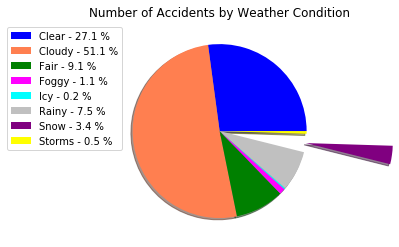

In [104]:
#create a pie plot of the various weather conditions and the number of accidents
x = counts["ID"]
colors = ["b", "coral", "g", "magenta", "cyan", "silver", "purple", "yellow"]
explode = [0,0,0,0,0,0,1,0]
plt.pie(x, startangle = 0, shadow = True, colors = colors, explode = explode)
y = counts["Weather"]
percent = 100*x/x.sum()
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(y, percent)]


plt.legend(labels = labels, loc = "upper left", bbox_to_anchor=(-.5,1))
plt.title("Number of Accidents by Weather Condition")
plt.savefig("Output/PiePlot.png")
plt.show()

In [63]:
#viewing number of accidents by severity
weather_gb = file_small.groupby(["Severity"]).count()["ID"]
weather_gb

Severity
1       17
2    18705
3     8826
4     2492
Name: ID, dtype: int64

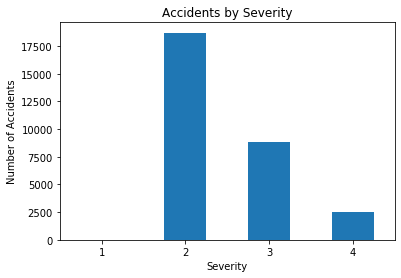

In [103]:
#bar graph by severity
weather_gb.plot(kind = "bar")
plt.ylabel("Number of Accidents")
plt.xticks(rotation = 0)
plt.title("Accidents by Severity")
plt.savefig("Output/Bar_Severity.png")

In [65]:
#evaluating how weather condtions effect severity 
weather_gb2 = file_small.groupby(["Weather"]).mean()["Severity"]
weather_gb2

Weather
Clear     2.417810
Cloudy    2.446263
Fair      2.548063
Foggy     2.493827
Icy       2.597015
Rainy     2.453273
Snow      2.682854
Storms    2.520548
Name: Severity, dtype: float64

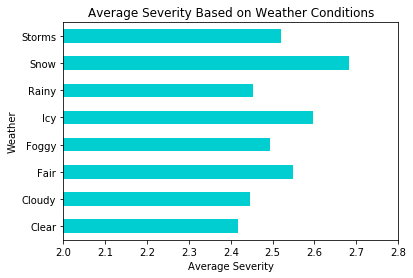

In [105]:
#plot the average severity by weather condtion
weather_gb2.plot(kind = "barh", color = "darkturquoise")
plt.xlabel("Average Severity")
plt.title("Average Severity Based on Weather Conditions")
plt.xlim((2, 2.8))
plt.savefig("Output/Bar_Sev_Weather.png")
plt.show()

In [67]:
#number of accidents and severity by weather condtion
weather_gb4 = file_small.groupby(["Weather","Severity"]).count()['ID']
weather_gb4 = weather_gb4.reset_index()
weather_gb4.head(10)

,Weather,Severity,ID
0,Clear,1,5
1,Clear,2,5347
2,Clear,3,1977
3,Clear,4,689
4,Cloudy,1,6
5,Cloudy,2,9474
6,Cloudy,3,4483
7,Cloudy,4,1129
8,Fair,1,2
9,Fair,2,1438


In [68]:
#moves severity to columns in order to be able to plot easier
pivot2_df = weather_gb4.pivot(index = "Weather", columns ="Severity", values = "ID")
pivot2_df = pivot2_df.fillna(0)
pivot2_df

Severity,1,2,3,4
Weather,,,,
Clear,5.0,5347.0,1977.0,689.0
Cloudy,6.0,9474.0,4483.0,1129.0
Fair,2.0,1438.0,1015.0,229.0
Foggy,1.0,202.0,81.0,40.0
Icy,1.0,35.0,21.0,10.0
Rainy,2.0,1393.0,634.0,186.0
Snow,0.0,477.0,375.0,157.0
Storms,0.0,79.0,58.0,9.0


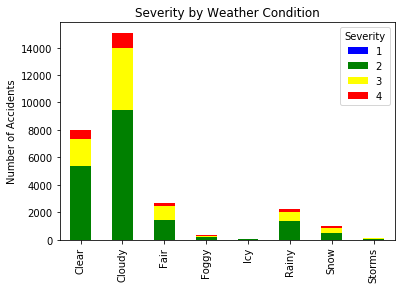

In [106]:
#creates a stacked bar graph based on number of accidents, severity, and weather conditions
colors = ["b", "g", "yellow", "red"]
pivot2_df.plot.bar(stacked = True, color = colors)
plt.ylabel("Number of Accidents")
plt.xlabel("")
plt.title("Severity by Weather Condition")
plt.savefig("Output/Bar_Sev_Weather_2.png")

In [70]:
#creates a df to view the count and severity by year
weather_gb3 = file_small.groupby(["Year", "Severity"]).count()["ID"]
weather_gb3 = weather_gb3.reset_index()
weather_gb3

,Year,Severity,ID
0,2016,2,739
1,2016,3,414
2,2016,4,470
3,2017,1,4
4,2017,2,4565
5,2017,3,1737
6,2017,4,641
7,2018,1,10
8,2018,2,9467
9,2018,3,3531


In [71]:
#changes the severity to columns to plot
pivot_df = weather_gb3.pivot(index = "Year", columns = "Severity", values = "ID")
pivot_df = pivot_df.fillna(0)
pivot_df

Severity,1,2,3,4
Year,,,,
2016,0.0,739.0,414.0,470.0
2017,4.0,4565.0,1737.0,641.0
2018,10.0,9467.0,3531.0,696.0
2019,3.0,3934.0,3144.0,685.0


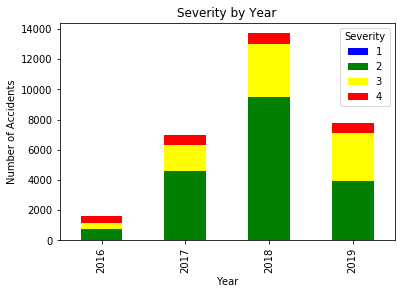

In [107]:
#stacked bar chart by year showing the number of accidents and severity
colors = ["b", "g", "yellow", "red"]
pivot_df.plot.bar(stacked=True, color = colors)
plt.title("Severity by Year")
plt.ylabel("Number of Accidents")
plt.savefig("Output/Bar_Acc_Year.png")
plt.show()

In [73]:
#######END CINDY######
#######START JOEL#####

In [74]:
file_small_j.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Description', 'City', 'County', 'State', 'Zipcode',
       'Temperature(F)', 'Weather_Condition', 'Time', 'Day', 'time_float',
       'Year', 'Weather'],
      dtype='object')

In [75]:
# Show only data for Weather, Year, and Count
dataset = file_small_j.groupby(['Weather', 'Year']).count()['City']
dataset = dataset.reset_index()
dataset = dataset.rename(columns={'City':'Count'})
dataset.head()

,Weather,Year,Count
0,Clear,2016,549
1,Clear,2017,2454
2,Clear,2018,4590
3,Clear,2019,424
4,Cloudy,2016,836


In [76]:
# Transpose the dataframe
dataset2 = dataset.pivot(index = 'Weather', columns = 'Year', values = 'Count')
dataset2

Year,2016,2017,2018,2019
Weather,,,,
Clear,549.0,2454.0,4590.0,424.0
Cloudy,836.0,3546.0,7164.0,3544.0
Fair,5.0,20.0,32.0,2627.0
Foggy,9.0,60.0,104.0,151.0
Icy,4.0,NaN,42.0,21.0
Rainy,111.0,586.0,1002.0,516.0
Snow,59.0,127.0,527.0,294.0
Storms,10.0,25.0,47.0,64.0


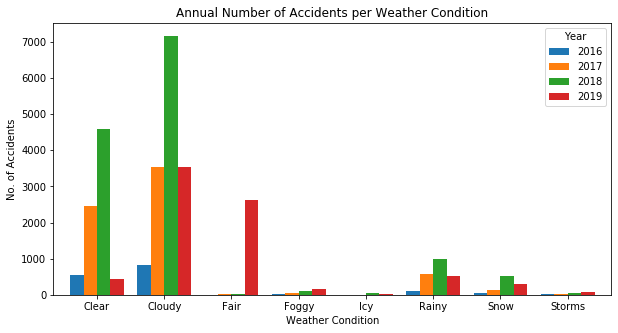

In [108]:
# Plot weather vs. # of accidents on grouped-bar-chart for each year
fig, ax = plt.subplots(figsize=(10,5))
data_chart = dataset2.plot.bar(width=0.8, ax=plt.gca())

# Chart formatting
plt.setp(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Weather Condition')
ax.set_ylabel('No. of Accidents')
ax.set_title('Annual Number of Accidents per Weather Condition')
plt.savefig("Output/Bar_Acc_Year_2.png")
plt.show()

In [78]:
####MIKE####

In [79]:
#define time bins based on integers
time_bins = [0,2,4,6, 8, 10,12, 14,16,18,20,22,24]
time_bin_names = ["12am - 2am", "2am - 4am", "4am - 6am", "6am -8am", "8am - 10am", "10am - 12pm",
                  "12pm - 2pm", "2pm -4pm", "4pm - 6pm", "6pm - 8pm", "8pm - 10pm", "10pm - 12pm" ]
file_small["time bins"] = pd.cut(file_small["time_float"], time_bins, labels=time_bin_names, include_lowest=True)
file_small.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Description,City,County,State,Zipcode,Temperature(F),Weather_Condition,Time,Day,time_float,Year,Weather,time bins
167968,A-167970,MapQuest,3,2016-12-12 18:33:39,2016-12-12 19:33:39,41.573952,-87.508942,Lane blocked and very slow traffic due to acci...,Hammond,Lake,IN,46324,14.7,Clear,18:33:39,Monday,18.550000,2016,Clear,6pm - 8pm
169508,A-169510,MapQuest,3,2017-01-12 17:47:21,2017-01-12 18:47:21,41.573952,-87.508942,Lane blocked and slow traffic due to accident ...,Hammond,Lake,IN,46324,24.6,Scattered Clouds,17:47:21,Thursday,17.783333,2017,Cloudy,4pm - 6pm
169625,A-169627,MapQuest,2,2017-01-16 07:50:35,2017-01-16 08:50:04,41.561283,-87.508972,Accident on Ridge Rd at Calumet Ave.,Munster,Lake,IN,46321,32.0,Overcast,07:50:35,Monday,7.833333,2017,Cloudy,6am -8am
169985,A-169987,MapQuest,3,2017-01-23 15:29:34,2017-01-23 15:58:37,41.573952,-87.508942,Left lane closed due to accident on I-80 Eastb...,Hammond,Lake,IN,46324,40.3,Overcast,15:29:34,Monday,15.483333,2017,Cloudy,2pm -4pm
170036,A-170038,MapQuest,2,2017-01-24 13:31:43,2017-01-24 14:01:17,38.477581,-87.566109,Accident on IN-56 at US-41.,Hazleton,Gibson,IN,47640-9212,42.1,Overcast,13:31:43,Tuesday,13.516667,2017,Cloudy,12pm - 2pm


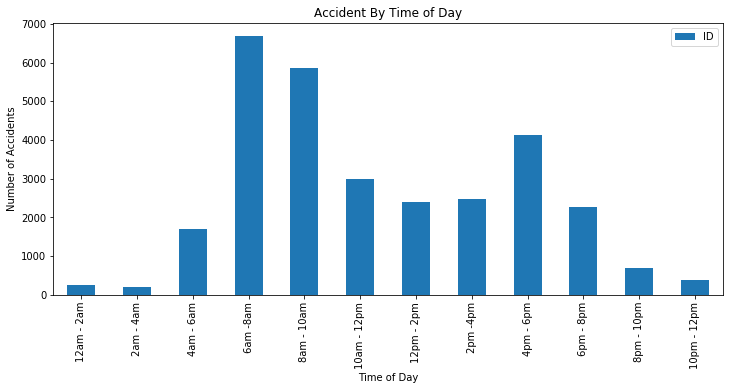

In [109]:
#create dataframe to illustrate number of accidents in each of the time bins
time_bin_df = pd.DataFrame(file_small)
time_bin_gb = time_bin_df.groupby(["time bins"]).count()["ID"]
#plot each bin in bar graph adding axis labels and title
time_chart = pd.DataFrame(time_bin_gb)
time_bin_gb.plot(kind='bar', title = "Accident By Time of Day", figsize=(12,5), legend = True)
#add labels
plt.xlabel ('Time of Day')
plt.ylabel ('Number of Accidents')
plt.savefig("Output/Bar_time.png")
plt.show()

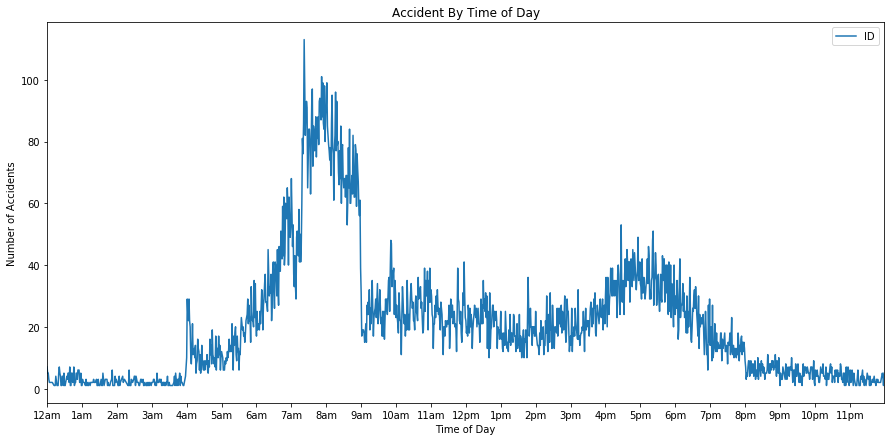

In [110]:
#create dataframe to count accidents and time stamps
time_bin_df = pd.DataFrame(file_small)
time_bin_gb = time_bin_df.groupby(["time_float"]).count()["ID"]
#graph in line chart accidents by hour
time_chart = pd.DataFrame(time_bin_gb)
time_bin_gb.plot(kind='line', title = "Accident By Time of Day", figsize=(15,7), legend = True)
plt.xticks(np.arange(24), ('12am',"1am","2am","3am","4am","5am","6am","7am","8am", "9am","10am","11am","12pm",
                           "1pm","2pm","3pm","4pm","5pm","6pm","7pm","8pm","9pm","10pm","11pm","12pm"))
#add labels
plt.xlabel ('Time of Day')
plt.ylabel ('Number of Accidents')
plt.savefig("Output/Line_time.png")
plt.show()

In [82]:
#Brad code starts here

In [83]:
yr = 2016

#group dataframe by Year and county
year_county_gb = file_small.groupby(["Year","County"])
#Get counts for each county each year
year_county_df = pd.DataFrame(year_county_gb.count())

#reset index so it can sort
year_county_df.reset_index(inplace=True)



#get unique Counties in a list
cty_list_i = file_small["County"].unique()

#Determine the average Lat and Lon for accidents in each county
county_gb_i = file_small.groupby(["County"])
lat_df_i = pd.DataFrame(county_gb_i["Start_Lat"].mean())
lon_df_i = pd.DataFrame(county_gb_i["Start_Lng"].mean())
county_df_i = pd.DataFrame(lat_df_i)
county_df_i = pd.merge(county_df_i,lon_df_i,on="County")
#county_df_i.head()
#Start_Lat

year_county_gb_i = file_small.groupby(["Year","County"])
year_county_df_i = pd.DataFrame(year_county_gb_i.count())
year_county_df_i = year_county_df_i.rename(columns={"ID":"Accident Count"})
year_county_df_i = year_county_df_i.drop(['Source', 'Severity', 'Start_Time', 'End_Time',
        'Start_Lat', 'Start_Lng', 'Description', 'City', 'State', 'Zipcode','time bins'], axis = 1)
year_county_df_i["Average Severity"]=year_county_gb_i['Severity'].mean()
year_county_df_i["Magnitude"]=year_county_df_i["Average Severity"]*year_county_df_i["Accident Count"]
#reset index to allow sorting
year_county_df_i.reset_index(inplace=True)
#year_county_df.head()
acc_cty_2016_df_i=year_county_df_i.loc[year_county_df["Year"]==yr]
acc_cty_2016_df_i=pd.merge(acc_cty_2016_df_i,county_df_i,how="left",on="County",)

#Create DF with just lat and long
loc_df_i = acc_cty_2016_df_i[["Start_Lat","Start_Lng"]].astype(float)
# Create a layer for heatmaps
fig_i = gmaps.figure(layout={
        'width': '900px',
        'height': '600px',
        'padding': '3px',
        'border': '1px solid black'})#,zoom_level=2,center=(a_lat,a_long),map_type="SATELLITE"

# Create a heatmap layer
hl_i = gmaps.heatmap_layer(loc_df_i, weights=acc_cty_2016_df_i["Magnitude"], 
                                 dissipating=False, max_intensity=acc_cty_2016_df_i["Magnitude"].median(),
                                 point_radius = .1)
#add heatmap layer
fig_i.add_layer(hl_i)
#display fig
fig_i

#Accident magnitude per county in Indiana for one year

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='900px'))

In [84]:
#processing file larger
fl_d = file_large.drop(columns = ['ID', 'Source', 'TMC',
       'End_Lat', 'End_Lng', 'Distance(mi)',
       'Number', 'Street', 'Side', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'])
#Convert to date time format
fl_d["Start_Time"] = pd.to_datetime(fl_d["Start_Time"])
                        #create time column
                        #fl_d["Time"]=fl_d["Start_Time"].apply(lambda t: t.time())
#create day name column
fl_d["Day"]=fl_d["Start_Time"].apply(lambda t: t.day_name())
#Create a column to allow binning by time, using a floating decimal form of time, 
#ex 4 = 4:00am or 4.5 = 4:30 or 13 = 1:00pm.
fl_d["time_float"]=fl_d["Start_Time"].apply(lambda t: (t.hour +(t.minute/60)))
#Create year column
fl_d["Year"]=fl_d["Start_Time"].apply(lambda t: t.year)
#Create column for groupby
fl_d["A"] = fl_d["County"].map(str) + " County, " + fl_d["State"].map(str)
                 

In [85]:
#define year for data
yr = 2019

#get unique Counties in a list.  A contains County, State so they are unique
cty_list_l = fl_d["A"].unique()
#sort by county
county_gb_l = fl_d.groupby(["A"])
#Determine the average Lat and Lon for accidents in each county
lat_df_l = pd.DataFrame(county_gb_l["Start_Lat"].mean())
lon_df_l = pd.DataFrame(county_gb_l["Start_Lng"].mean())
county_df_l = pd.DataFrame(lat_df_l)
#merge on state and county for larger dataset
county_df_l = pd.merge(county_df_l,lon_df_l,on=["A"])
#reset index to allow sorting
county_df_l.reset_index(inplace=True)
#rename columnns
county_df_l = county_df_l.rename(columns={"A":"County, State"})
#reset index to allow sorting or column name change
year_county_gb_l = fl_d.groupby(["Year","A"])
year_county_df_l = pd.DataFrame(year_county_gb_l.count())

#rename count column
year_county_df_l = year_county_df_l.rename(columns={"Severity":"Accident Count"})

#claculate average severity for each county
year_county_df_l["Average Severity"]=year_county_gb_l['Severity'].mean()
#calcualte the magnitude for each county multiply accidents by avg severity.
year_county_df_l["Magnitude"]=year_county_df_l["Average Severity"]*year_county_df_l["Accident Count"]

#reset index to allow soring
year_county_df_l.reset_index(inplace=True)
#rename columns
year_county_df_l = year_county_df_l.rename(columns={"A":"County, State"})


#clean up dataframe
year_county_df_l = year_county_df_l.drop(['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Description', 'City', 'County', 'State', 'Zipcode', 'Country',
       'Timezone', 'Weather_Condition', 'Day', 'time_float'], axis = 1)


#sort by year value
acc_year_l=year_county_df_l.loc[year_county_df_l["Year"]==yr]
#Combine avg lat and long values for each county into accident data
acc_year_l=pd.merge(acc_year_l,county_df_l,how="left",on="County, State")


# #Create DF with just lat and long
loc_df_l = acc_year_l[["Start_Lat","Start_Lng"]].astype(float)
 # Create a layer for heatmaps
fig_l = gmaps.figure(layout={
         'width': '900px',
         'height': '600px',
         'padding': '3px',
         'border': '1px solid black'})#,zoom_level=2,center=(a_lat,a_long),map_type="SATELLITE"

# # Create a heatmap layer
hl_l = gmaps.heatmap_layer(loc_df_l, weights=acc_year_l["Magnitude"], 
                                  dissipating=False, max_intensity=acc_year_l["Magnitude"].median(),
                                  point_radius = .1)


# #add heatmap layer
fig_l.add_layer(hl_l)


# #display fig
fig_l

#NAtional head map of accidents by county for one year, see yr value above.

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='900px'))

In [86]:
#seperate the data into years
acc_year_2016=year_county_df_l.loc[year_county_df_l["Year"]==2016]
acc_year_2017=year_county_df_l.loc[year_county_df_l["Year"]==2017]
acc_year_2018=year_county_df_l.loc[year_county_df_l["Year"]==2018]
acc_year_2019=year_county_df_l.loc[year_county_df_l["Year"]==2019]

#Calculate the annual,total and average change
yrly_df=pd.merge(acc_year_2016,acc_year_2017,how="outer",on="County, State",suffixes=('_2016', '_2017'))
yrly_df=pd.merge(yrly_df,acc_year_2018,how="outer",on="County, State",suffixes=(" ", '_2018'))
yrly_df=pd.merge(yrly_df,acc_year_2019,how="outer",on="County, State",suffixes=('_2018', '_2019'))
yrly_df = yrly_df.drop(['Year_2016','Year_2017','Year_2018','Year_2019'],axis = 1)
#sort out values with less than X number of accidents in all years. Otherwise any data starting with very low numbers
#have very high changes. Very low numbers in entire years shows reporting irregularities.
min_acc = 100
yrly_df=yrly_df.loc[(yrly_df["Accident Count_2016"] > min_acc) & (yrly_df["Accident Count_2017"]>min_acc) & 
                    (yrly_df["Accident Count_2018"]>min_acc) & (yrly_df["Accident Count_2019"]>min_acc)]

#Calculate rate of change for each period

yrly_df["Mag 16-17"]=((yrly_df['Magnitude_2017']-yrly_df['Magnitude_2016'])/yrly_df['Magnitude_2016'])*100
yrly_df["Mag 17-18"]=((yrly_df['Magnitude_2018']-yrly_df['Magnitude_2017'])/yrly_df['Magnitude_2017'])*100
yrly_df["Mag 18-19"]=((yrly_df['Magnitude_2019']-yrly_df['Magnitude_2018'])/yrly_df['Magnitude_2018'])*100
yrly_df["Mag 16-19"]=((yrly_df['Magnitude_2019']-yrly_df['Magnitude_2016'])/yrly_df['Magnitude_2016'])*100
yrly_df["Avg Yr Chg"]=(yrly_df["Mag 16-17"]+yrly_df["Mag 17-18"]+yrly_df['Mag 18-19'])/3


In [87]:
yrly_df = yrly_df.sort_values('Avg Yr Chg',ascending=False)
sorted_yrly_df = yrly_df.head(20)

In [88]:

rec_num = 20  #num or records to display
#sort values and take top rec_num
yrly_df = yrly_df.sort_values('Avg Yr Chg',ascending=False)
sorted_yrly_df = yrly_df.head(rec_num)

#rename lat and lon county state column
county_df_l = county_df_l.rename(columns={"A":"County, State"})

#merge lat and lon data into set
sorted_yrly_df=pd.merge(sorted_yrly_df,county_df_l,how="left",on="County, State")

#create hover data
sorted_yrly_df["h"] = sorted_yrly_df["County, State"] + \
                        " 2016: " + sorted_yrly_df["Accident Count_2016"].astype(int).astype(str) + \
                        ", 2017: " + sorted_yrly_df["Accident Count_2017"].astype(int).astype(str) + \
                        ", 2018: " + sorted_yrly_df["Accident Count_2018"].astype(int).astype(str) + \
                        ", 2019: " + sorted_yrly_df["Accident Count_2018"].astype(int).astype(str) + \
                        ", Avg: "  + sorted_yrly_df["Avg Yr Chg"].map('{:.2f}%'.format)

#create hover lst
hov = []
hov = sorted_yrly_df["h"].tolist()

# Using the template add the hotel marks to the heatmap
info_box_template = """<dl>
<dt>County, State</dt><dd>{County, State}</dd>
<dt>Accident Totals</dt>
<dt>2016:</dt>{Accident Count_2016}</dd>
<dt>2017</dt><dd>{Accident Count_2017}</dd>
<dt>2018</dt><dd>{Accident Count_2018}</dd>
<dt>2019</dt><dd>{Accident Count_2019}</dd>
</dl>"""

# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
a_info = [info_box_template.format(**row) for index, row in sorted_yrly_df.iterrows()]

# #Create DF with just lat and long
loc_df_l = sorted_yrly_df[["Start_Lat","Start_Lng"]].astype(float)
 # Create a layer for heatmaps
fig_s = gmaps.figure(layout={
         'width': '900px',
         'height': '600px',
         'padding': '3px',
         'border': '1px solid black'})#,zoom_level=2,center=(a_lat,a_long),map_type="SATELLITE"

# # Create a heatmap layer
hl_s = gmaps.heatmap_layer(loc_df_l, weights=sorted_yrly_df["Avg Yr Chg"], 
                                  dissipating=False, max_intensity=sorted_yrly_df["Avg Yr Chg"].median(),
                                  point_radius = 0.5)
#create symbol layer
sym = gmaps.symbol_layer(loc_df_l, info_box_content=a_info, hover_text= hov,fill_color=None,
    fill_opacity=0.0,
    stroke_color=None,
    stroke_opacity=0.0,
    scale=3,)

# #add heatmap layer
fig_s.add_layer(hl_s)
fig_s.add_layer(sym)


# #display fig
fig_s

#top 20 areas by percent change of accidents each year

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='900px'))

In [89]:
#Dictionary courtesy of https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


In [90]:
#rename sensus column
cen_file_df = cen_file.rename(columns={"NAMELSAD":"County, State"})
#split county and state so state can be manipulated.
new = cen_file_df["County, State"].str.split(", ",n = 1,expand = True)

#Move census columnns to individual serieses
cen_file_df["County"] = new[0]
cen_file_df["State"] = new[1]

#create new list for state abreviations
new2 =[]


#utilize dictionary to create new list of state abreviations
for a in new[1]:
    try:
        #print(us_state_abbrev[a])
        new2.append(us_state_abbrev[a])
#DC does not have a state, need to have null for this state.
    except:   
        new2.append("")
        #print("")  

#Copy state abreviations to column in DF
cen_file_df["a"] = new2       

In [91]:
#align census county and state with the accident data.
cen_file_df["County, State"] =  cen_file_df["County"] + ", " + cen_file_df["a"]
cen_df = cen_file_df.drop(columns=["County","State","a"])
cen_df["County, State"] = cen_df["County, State"].str.replace("Parish","County")

In [92]:
#merge dataframes of accident data and census data
yrly_df_pop = pd.merge(yrly_df,cen_df,on="County, State",how="left")

In [93]:
#calculate the accident rate per 1000 residents

yrly_df_pop["2016 pp"]=(yrly_df_pop['Accident Count_2016']/yrly_df_pop['POP'])*1000
yrly_df_pop["2017 pp"]=(yrly_df_pop['Accident Count_2017']/yrly_df_pop['POP'])*1000
yrly_df_pop["2018 pp"]=(yrly_df_pop['Accident Count_2018']/yrly_df_pop['POP'])*1000
yrly_df_pop["2019 pp"]=(yrly_df_pop['Accident Count_2019']/yrly_df_pop['POP'])*1000
yrly_df_pop["All pp"]=(((yrly_df_pop['Accident Count_2016']+yrly_df_pop['Accident Count_2017']+\
                       yrly_df_pop['Accident Count_2018']+yrly_df_pop['Accident Count_2019'])/4)/yrly_df_pop['POP'])*1000

In [94]:
#define the minimum number of accidents required in each year
#allowing too small a minimum allows areas with very small numbers to show extreme change even though realistially it's not a
#big deal
min_acc_pop = 100
yrly_df_pop_sort=yrly_df_pop.loc[(yrly_df_pop["Accident Count_2016"] > min_acc_pop) & (yrly_df_pop["Accident Count_2017"]>min_acc_pop) & 
                    (yrly_df_pop["Accident Count_2018"]>min_acc_pop) & (yrly_df_pop["Accident Count_2019"]>min_acc_pop)]

#Number of records to display
rec_num_pop = 20  #num or records to display
#sort values and take top rec_num
yrly_df_pop_sort = yrly_df_pop_sort.sort_values('All pp',ascending=False)
#copy only number of records to display to dataframe
yrly_df_pop_sort = yrly_df_pop_sort.head(rec_num_pop)

#rename lat and lon county state column
#county_df_l = county_df_l.rename(columns={"A":"County, State"})

#merge lat and lon data into set
yrly_df_pop_sort=pd.merge(yrly_df_pop_sort,county_df_l,how="left",on="County, State")

#create hover data
yrly_df_pop_sort["h"] = yrly_df_pop_sort["County, State"] + "  "\
                        "Population: " + yrly_df_pop_sort["POP"].map('{:.0f}'.format) + \
                        " 2016: " + yrly_df_pop_sort["2016 pp"].map('{:.2f}'.format) + \
                        ", 2017: " + yrly_df_pop_sort["2017 pp"].map('{:.2f}'.format) + \
                        ", 2018: " + yrly_df_pop_sort["2018 pp"].map('{:.2f}'.format) + \
                        ", 2019: " + yrly_df_pop_sort["2019 pp"].map('{:.2f}'.format) + \
                        ", Avg: "  + yrly_df_pop_sort["All pp"].map('{:.2f}'.format)

#create list to place hover values 
hov = []
hov = yrly_df_pop_sort["h"].tolist()

# Using the template add the hotel marks to the heatmap
info_box_template = """<dl>
<dt>County, State</dt><dd>{County, State}</dd>
<dt>Accidents per Person</dt>
<dt>Population:</dt>{POP}</dd>
<dt>2016:</dt>{2016 pp}</dd>
<dt>2017</dt><dd>{2017 pp}</dd>
<dt>2018</dt><dd>{2018 pp}</dd>
<dt>2019</dt><dd>{2019 pp}</dd>
<dt>Avg</dt><dd>{All pp}</dd>
</dl>"""

# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
a_info = [info_box_template.format(**row) for index, row in yrly_df_pop_sort.iterrows()]

# #Create DF with just lat and long
loc_df_l_pop = yrly_df_pop_sort[["Start_Lat","Start_Lng"]].astype(float)
 # Create a layer for heatmaps
fig_p = gmaps.figure(layout={
         'width': '900px',
         'height': '600px',
         'padding': '3px',
         'border': '1px solid black'})#,zoom_level=2,center=(a_lat,a_long),map_type="SATELLITE"

# # Create a heatmap layer
hl_p = gmaps.heatmap_layer(loc_df_l_pop, weights=yrly_df_pop_sort["All pp"], 
                                  dissipating=False, max_intensity=yrly_df_pop_sort["All pp"].median(),
                                  point_radius = .3)
#create symbol layer
sym_p = gmaps.symbol_layer(loc_df_l_pop, info_box_content=a_info, hover_text= hov,fill_color='black',
    fill_opacity=0.0,
    stroke_color=None,
    stroke_opacity=0.0,
    scale=3,)

# #add heatmap layer
fig_p.add_layer(hl_p)
fig_p.add_layer(sym_p)
fig_p.title = "dd"

# #display fig
fig_p

#Shows top 20 locations in US with most number of accidents per 1,000 people from census data

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='900px'))